# Processing the power spectra

This notebook loads the pickle files that contain the power spectra for each participant. It also writes the relevant data (regression slope, intercept) to file, and plots it so you can check everything looks good.

Data is written to separate CSV files depending on where it comes from. The following are produced:

```
../csv/
    |--megbehavior.csv
    |--rest.csv
    |--task.csv
    |--agesplit-spectra.csv
    |--vstm-behavior.csv
```

In [1]:
# path operations
from glob import glob
import os
from pathlib import Path

# data format and storage
from collections import namedtuple
import pickle

# numerical tools
import numpy as np
import scipy.stats
import pandas as pd
import scikit.bootstrap as boot

# for cluster stats, we need to make partial functions
from functools import partial

# plotting tools
from matplotlib import pyplot as plt
# %matplotlib notebook
import matplotlib.cm
import matplotlib.colors
# custom function
from plotting_aids import plot_linfit

# interactive notebook features
try:
    from tqdm import tqdm_notebook as tqdm
except:
    from tqdm import tqdm
from ipywidgets import interact

# meg analysis
import mne

### Load the task data from the pickles:

Define the data structure for the summary data:
(Using namedtuple for this)

In [2]:
sub_params = namedtuple('sub_params',
                        ['pid', 'slopes', 'age', 'gender',
                         'intercepts', 'rsquared'])

Define the filepaths:

In [3]:
# camcanroot = Path('/Volumes') / 'Seagate Expansion Drive' /'camcan'
# camcanroot = Path('D:') / 'camcan'
# camcanroot = Path('/data') / 'group' / 'FANS' / 'camcan-meg' / 'camcan165' / 'camcan165'
camcanroot = Path('/Users') / 'jan' / 'Documents' / 'eeg-data' / 'camcan'
# specific paths
megdataroot = camcanroot / 'cc700' / 'mri' / 'pipeline' / 'release004' / 'BIDSsep' / 'megraw'
megfiles = list(megdataroot.glob('*/meg/task_raw.fif'))
pickleroot = Path('.') / 'pickles'
csvroot = Path('.') / 'csv'


In [4]:
raw = mne.io.read_raw_fif(megfiles[0])

channel_names = [raw.ch_names[i] for i in mne.pick_types(raw.info, meg='grad')]

Opening raw data file /Users/jan/Documents/eeg-data/camcan/cc700/mri/pipeline/release004/BIDSsep/megraw/sub-CC110033/meg/task_raw.fif...
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 16000 ... 557999 =     16.000 ...   557.999 secs
Ready.
Current compensation grade : 0


In [5]:
pos = mne.channels.layout._auto_topomap_coords(
            raw.info, mne.pick_types(raw.info, meg='grad')[0::2]
        )

Load the task data

In [6]:
psds = {}
picklelist = {}
ids = {}
# load the task data from pickles
for recording in ['rest', 'task']:
    picklelist[recording] = list(pickleroot.glob(pattern='*' + recording + '.pickle'))
    print(f'{len(picklelist[recording])} {recording} files found.')
    tuplist = [pickle.load(open(f, 'rb')) for f in picklelist[recording]]
    tuplist = list(zip(*tuplist))
    psds[recording] = list(tuplist[0])
    ids[recording] = [file.name[0:8] for file in picklelist[recording]]


643 rest files found.
640 task files found.


In [7]:
subject_details = pd.DataFrame.from_csv(camcanroot / 'cc700-scored' / 'participant_data.csv')

Re-do the linear regression for each subject to populate the data structure

In [8]:
# re-construct the frequencies that were used to evaluate the PSD:
freqs = np.linspace(2, 24, num=psds['task'][0].shape[-1])
# the frequencies over which the line should be fit:
findices = (freqs > 14) | (freqs < 7)

summary_data = {'rest': [], 'task': []}

for name, data in tqdm(psds.items()):
    for subject, psd in tqdm(enumerate(data)):
        # Do the linear regression
        linfits = [scipy.stats.linregress(freqs[findices], np.log10(psd.T[findices, grad]))
                   for grad in range(psd.shape[0])]
        summary_data[name].append(
            sub_params(pid=ids[name][subject],
                       slopes=np.array([l.slope for l in linfits]),
                       intercepts=np.array([l.intercept for l in linfits]),
                       rsquared=np.array([l.rvalue**2 for l in linfits]),
                       age=subject_details.loc[ids[name][subject], 'age'],
                       gender=1)
        )

In [9]:
bad_elecs = {'rest': [], 'task': []}

for name, data in summary_data.items():
    for p in data:
        bads = np.zeros_like(p.rsquared, dtype='bool')
        bads = bads | (p.slopes > 0)
        bads = bads | (p.intercepts >
                       p.intercepts.mean() +
                       2 * p.intercepts.std())
        bads = bads | (p.intercepts <
                       p.intercepts.mean() -
                       2 * p.intercepts.std())
        bad_elecs[name].append(bads)


### Save the data to CSV files

In [10]:
for recording in list(summary_data.keys()):
    outdicts = [{
        'pid': p.pid,
        'removed_elecs': e.sum(),
        'average.slope': p.slopes[~e].mean(),
        'average.intercept': p.intercepts[~e].mean(),
        'average.rsquared': p.rsquared[~e].mean(),
        'age': p.age,
        'sex': p.gender
    }
        for p, e in zip(summary_data[recording],
                        bad_elecs[recording])
    ]
    
    with open(csvroot / (recording + '.csv'), 'w+') as f:
        pd.DataFrame.from_dict(outdicts).to_csv(f, index=False)


# Visualising data

Now we're gonna plot the data. First, we define a color scheme:

In [11]:
a = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap='viridis')

colorscheme = {'rest': 'lightblue',
               'task': 'pink',
               'old': a.to_rgba(0.75),
               'young': a.to_rgba(0.25)}

### Compare resting-state to task

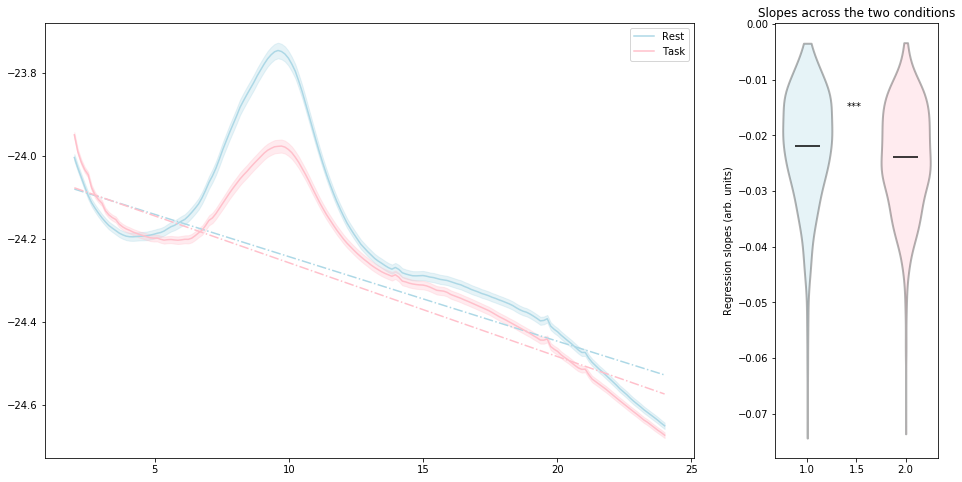

In [12]:
x = freqs
plt.figure(figsize=(16, 8))

# actually plot the spectra
plt.subplot2grid((1, 4), (0, 0), colspan=3)
lines = []
colors = [[1, 0.4, 0.4], [0.4, 0.4, 1]]
labels = ['Task', 'Rest']
for name, data in psds.items():
    
    pltdata = np.log10(
        np.stack([p[~e, :].mean(axis=0) for p, e in zip(data, bad_elecs[name])],
                 axis=-1)
    )
    
    line = plt.plot(x, np.mean(pltdata, axis=-1),
                    color=colorscheme[name], label=name.capitalize())
    lines.append(line)
    
    # regression line
    linfit = scipy.stats.linregress(freqs[findices], np.mean(pltdata, axis=-1)[findices])
    x2 = np.array([freqs.min(), freqs.max()])
    y2 = linfit.slope*x2 + linfit.intercept
    plt.plot(x2, y2, '-.', color=colorscheme[name])
    
    plt.fill_between(
            x, np.mean(pltdata, axis=-1)-scipy.stats.sem(pltdata, axis=-1),
            np.mean(pltdata, axis=-1)+scipy.stats.sem(pltdata, axis=-1),
            color=colorscheme[name], alpha=0.3
        )
    plt.legend()

# plot the slopes between settings
ax = plt.subplot2grid((1, 4), (0, 3))
plt.title('Slopes across the two conditions')
plt.ylabel('Regression slopes (arb. units)')

# collect all the average slopes
slopevecs = [[p.slopes[~e].mean() for p, e in zip(data, bad_elecs[name])]
             for name, data in summary_data.items()]
# plot the boxes
boxplt = plt.violinplot(slopevecs, showextrema=False, showmeans=True)
# color the boxes appropriately
boxplt['cmeans'].set_color('black')
for b, n in zip(boxplt['bodies'], psds.keys()):
    b.set_facecolor(colorscheme[n])
    b.set_edgecolor('black')
    b.set_linewidth(2)

if scipy.stats.ttest_ind(*slopevecs).pvalue < 0.001:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='***')
elif scipy.stats.ttest_ind(*slopevecs).pvalue < 0.01:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='**')
elif scipy.stats.ttest_ind(*slopevecs).pvalue < 0.05:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='*')
else:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='n.d.')

plt.subplots_adjust(wspace=0.5)
plt.show()

### Check if the two correlate

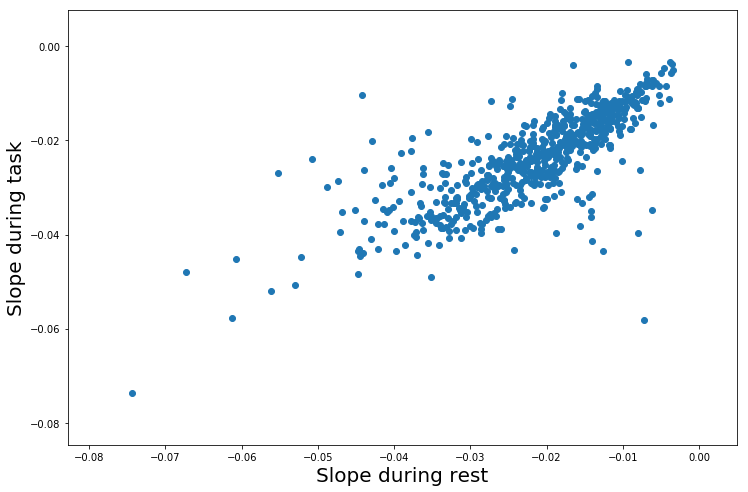

(0.77567850605251365, 4.840995104850859e-129)


In [13]:
ids = {name: [p.pid for p in data]
       for name, data in summary_data.items()}

coords = [[np.mean(p.slopes[~e]) for p, e in zip(data, bad_elecs[name])
          if p.pid in ids['rest'] and p.pid in ids['task']]
          for name, data in summary_data.items()]
# x = [np.mean(p.slopes[~e]) for p, e in zip(summary_data['rest'], bad_elecs) if p.pid in restids]
# y = [np.mean(p.slopes[~e]) for p, e in zip(restall_parameters, restbad_elecs) if p.pid in taskids]

plt.figure(figsize=(12, 8))
plt.scatter(coords[0], coords[1])
plt.xlabel(f'Slope during {list(summary_data.keys())[0]}', fontsize=20)
plt.ylabel(f'Slope during {list(summary_data.keys())[1]}', fontsize=20)
plt.show()

print(scipy.stats.pearsonr(*coords))

### Make a split power spectrum for age groups in `task`

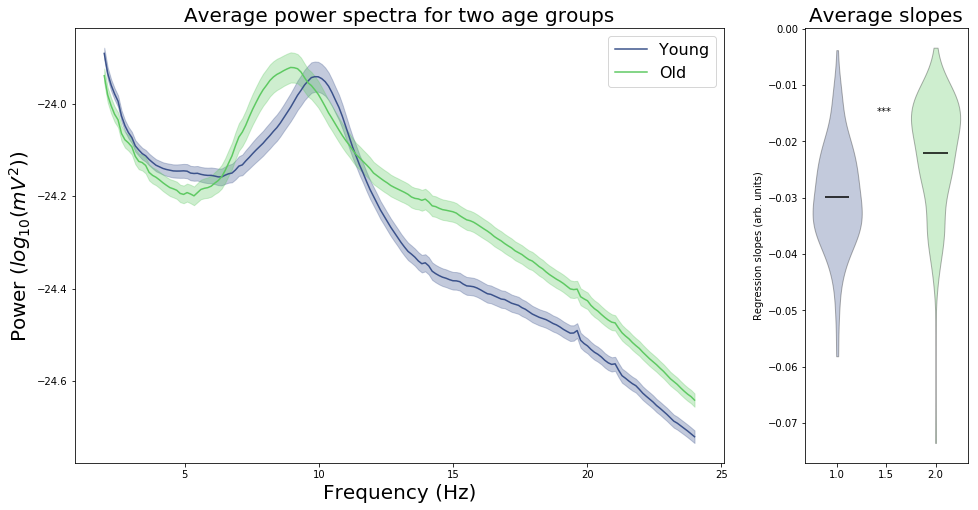

In [14]:
recording= 'task'

ages = np.array([p.age for p in summary_data[recording]])
agesplit = {'young': ages < np.percentile(ages, 25),
            'old': ages > np.percentile(ages, 75)}

young = ages < np.percentile(ages, 25)
old = ages > np.percentile(ages, 75)

plt.figure(figsize=(16, 8))

plt.subplot2grid((1, 4), (0, 0), colspan=3)
legendentries = []
for groupname, group in agesplit.items():
    pltdata = np.log10(np.stack([p[~e, :].mean(axis=0)
                                 for p, e, g in zip(psds[recording], bad_elecs[recording], group)
                                 if g],
                                axis=-1))
    plt.fill_between(
        freqs,
        np.mean(pltdata, axis=-1)-scipy.stats.sem(pltdata, axis=-1),
        np.mean(pltdata, axis=-1)+scipy.stats.sem(pltdata, axis=-1),
        color=colorscheme[groupname], alpha=0.3
    )
    legendentries.append(plt.plot(freqs, np.mean(pltdata, axis=-1),
                                  color=colorscheme[groupname],
                                  label=groupname.capitalize()))

plt.ylabel('Power ($log_{10}(mV^2)$)', fontsize=20)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.title('Average power spectra for two age groups', fontsize=20)
plt.legend(fontsize=16)

# plot the slopes between settings
ax = plt.subplot2grid((1, 4), (0, 3))
plt.title('Average slopes', fontsize=20)
plt.ylabel('Regression slopes (arb. units)')

# collect all the average slopes
slopevecs = [[p.slopes[~e].mean()
              for i, (p, e) in enumerate(zip(summary_data[recording], bad_elecs[recording]))
              if g[i]]
             for groupname, g in agesplit.items()]
# plot the boxes
violins = plt.violinplot(slopevecs, showextrema=False, showmeans=True)
# color the boxes appropriately
for patch, groupname in zip(violins['bodies'], agesplit.keys()):
    patch.set_facecolor(colorscheme[groupname])
    patch.set_edgecolor('black')
    patch.set_alpha(0.3)
# make the mean line black
violins['cmeans'].set_color('black')

if scipy.stats.ttest_ind(*slopevecs).pvalue < 0.001:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='***')
elif scipy.stats.ttest_ind(*slopevecs).pvalue < 0.01:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='**')
elif scipy.stats.ttest_ind(*slopevecs).pvalue < 0.05:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='*')
else:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='n.d.')

plt.subplots_adjust(wspace=0.5)
plt.show()

In [15]:
# write the split data to a csv file
outdicts = [
    {
        **{'pid': p.pid, 'group': 'young' if p.age < np.percentile(ages, 25) else 'old'},
        **{str(freq): power for freq, power in zip(freqs, np.log10(psd[~e, :]).mean(axis=0))}
    }
    for p, e, psd in zip(summary_data[recording], bad_elecs[recording], psds[recording])
    if (p.age < np.percentile(ages, 25)) or (p.age > np.percentile(ages, 75))
]

with open(csvroot / 'agesplit-spectra.csv', 'w+') as f:
    pd.DataFrame.from_dict(outdicts).to_csv(f, index=False)

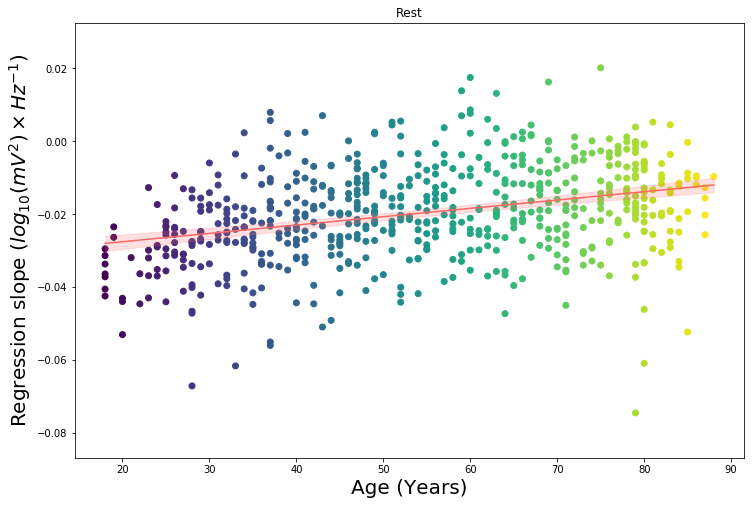

(0.32779759801901742, 1.4283409117012871e-17)


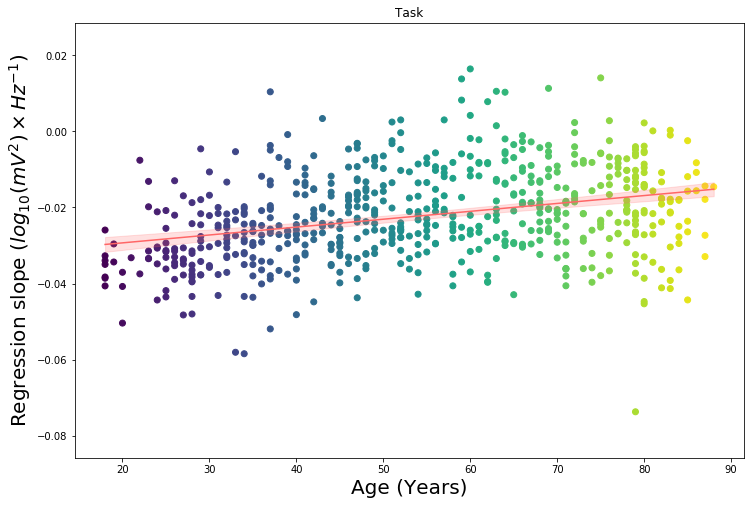

(0.32034726701665406, 9.7072295445765612e-17)


In [16]:
for recording, data in summary_data.items():
    x = np.array([p.age for p in data])
    y = np.array([np.mean(p.slopes) for p in data])
    plt.figure(figsize=(12, 8))
    plt.scatter(x, y, c=x)
    plot_linfit(x, y)
    plt.xlabel(r'Age (Years)', fontsize=20)
    plt.ylabel(r'Regression slope ($log_{10}(mV^2) \times Hz^{-1}$)', fontsize=20)
    plt.title(recording.capitalize())
    plt.show()
    print(scipy.stats.pearsonr(x, y))


In [17]:
# Load the short-term memory data
stm = pd.read_csv(
    camcanroot / 'cc700-scored' / 'VSTMcolour' / 'release001' / 'summary' / 'VSTMcolour_summary.txt',
    sep='\t', skiprows=8, index_col=0
)

with open(csvroot / 'vstm-behavior.csv', 'w+') as f:
    stm.to_csv(f)

(-0.066509719757944133, 0.10077311325520133)


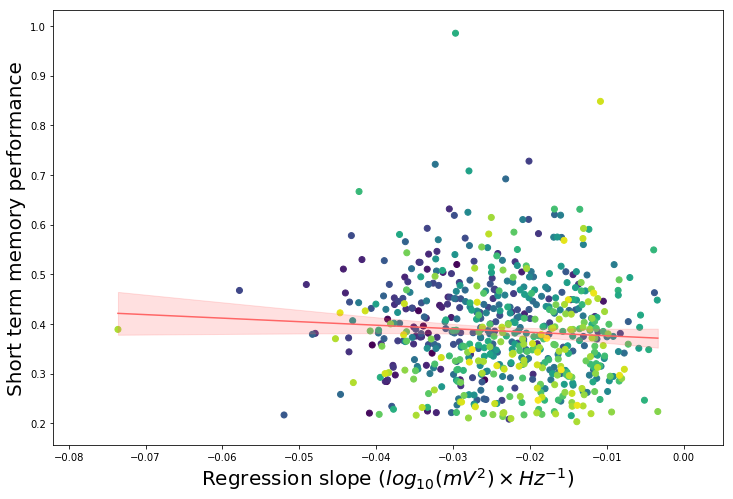

In [18]:
recording = 'task'

ages = np.array([p.age for p in summary_data[recording] if p.pid in stm.index])
slopes = [np.mean(p.slopes[~e])
          for p, e in zip(summary_data[recording], bad_elecs[recording])
          if p.pid in stm.index]

x = np.array(slopes)
y = np.array(
    [float(stm.loc[p.pid, 'Prcsn_ss3']) for p in summary_data[recording] if p.pid in stm.index]
)
# exclusion params
include = y < 1

x = x[include]
y = y[include]
c = ages[include]

print(scipy.stats.pearsonr(x, y))

plt.figure(figsize=(12, 8))
plt.scatter(x, y, c=c)
plot_linfit(x, y)
plt.ylabel(r'Short term memory performance', fontsize=20)
plt.xlabel(r'Regression slope ($log_{10}(mV^2) \times Hz^{-1}$)', fontsize=20)
plt.show()

(-0.0075748607959751834, 0.84974013832389983)


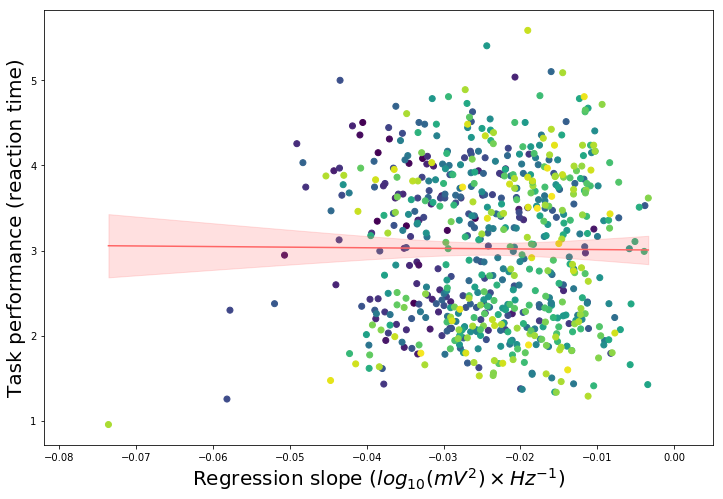

In [19]:
recording = 'task'

megbehaviorroot = camcanroot / 'cc700-scored' / 'MEG' / 'release001' / 'data'
megmeanrt = []
megmedianrt = []

ages = []

rtdicts = []

for p in summary_data[recording]:
    try:
        meg_behaviour = pd.read_csv(
            megbehaviorroot / p.pid / ('MEG_' + p.pid + '_scored.txt'), sep='\t'
        )
        meanrt = meg_behaviour.loc[0, 'mRT_inv_trim']
        medianrt = meg_behaviour.loc[0, 'mdnRT_inv_trim']
        megmeanrt.append(meanrt)
        megmedianrt.append(medianrt)
        ages.append(p.age)
        rtdicts.append({'pid': p.pid, 'age': p.age,
                        'mean.rt': meanrt,
                        'median.rt': medianrt})
    except:
        ages.append(np.nan)
        megmeanrt.append(np.nan)
        megmedianrt.append(np.nan)



slopes = np.array([np.mean(p.slopes[~e]) for p, e in zip(summary_data[recording], bad_elecs[recording])])

x = slopes
y = np.array(megmedianrt)
include = (~np.isnan(x) & ~np.isnan(y))
x = x[include]
y = y[include]
c = np.array(ages)[include]

print(scipy.stats.pearsonr(x, y))

plt.figure(figsize=(12, 8))
plt.scatter(x, y, c=c)
plot_linfit(x, y)
plt.ylabel(r'Task performance (reaction time)', fontsize=20)
plt.xlabel(r'Regression slope ($log_{10}(mV^2) \times Hz^{-1}$)', fontsize=20)
plt.show()

In [20]:
with open(csvroot / 'megbehavior.csv', 'w+') as f:
    pd.DataFrame.from_dict(rtdicts).to_csv(f, index=False)

---

# Check if correlations are locally more strong


### Costom correlation function for clustering

In [108]:
# use this function to make a function that correlates with a fixed vector
def corrtest(y):
    def correlate_t_transform(y, x):
        ts = np.zeros(x.shape[-1])
        for sensor in range(x.shape[-1]):
            # run the pearson correlation
            include = ~np.isnan(y) & ~np.isnan(x[..., sensor])
            r, p = scipy.stats.pearsonr(y[include], x[include, sensor])
            # t-transorm
            ts[sensor] = r / np.sqrt((1 - r**2) / (len(x) - 2))
        return ts
    return partial(correlate_t_transform, y)

# use this function for the bootstrap (no p values)
def pearsonr_nop(x, y):
    r, _ = scipy.stats.pearsonr(x, y)
    return r

### Cluster analysis: 1/f noise and age



stat_fun(H1): min=1.685991 max=10.997090
Running initial clustering
Found 1 clusters
Permuting ...
[........................................] 100.00000 |    Computing cluster p-values
Done.


stat_fun(H1): min=-0.010603 max=11.715988
Running initial clustering
Found 1 clusters
Permuting ...
[........................................] 100.00000 |    Computing cluster p-values
Done.


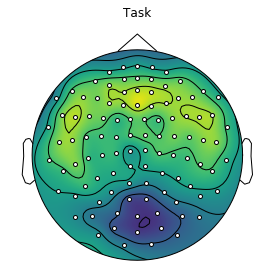

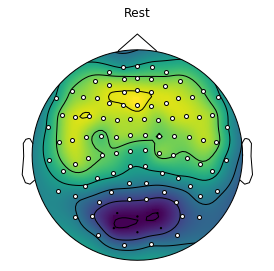

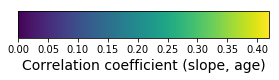

In [183]:
rvals = {}
pvals = {}
obs = {}
clusters = {}
cluster_pvs = {}
rcis = {}

for i, recording in enumerate(['task', 'rest']):
    
    rvals[recording], pvals[recording], rcis[recording] = [], [], []
    
    y = np.array([p.age for p in summary_data[recording]])

    # set things up for the cluster analysis
    connectivity, ch_names = mne.channels.read_ch_connectivity('neuromag306mag')
    obs[recording] = np.zeros((y.size, len(ch_names)))

    for channel in tqdm(range(0, len(summary_data[recording][0].slopes), 2)):

        slopes = np.array(
            [np.mean([p.slopes[channel], p.slopes[channel+1]])
             if not e[channel] else np.nan
             for p, e in zip(summary_data[recording], bad_elecs[recording])]
        )

        obs[recording][:, channel//2] = slopes

        # exclude individuals for which this channel was bad
        include = ~np.isnan(slopes) & ~np.isnan(y)

        rval, pval = scipy.stats.pearsonr(slopes[include], y[include])
        rvals[recording].append(rval)
        pvals[recording].append(pval)
        
        # calculate the confidence intervals for the corr coefficient
        

    rvals[recording] = np.array(rvals[recording])
    pvals[recording] = np.array(pvals[recording])

    corrt = corrtest(y)


    _, clusters[recording], cluster_pvs[recording], _ = mne.stats.permutation_cluster_1samp_test(
        obs[recording], stat_fun=corrt, connectivity=connectivity, threshold=scipy.stats.t.isf(0.05, len(y)))


for recording in ['task', 'rest']:
    # plot, with the appropriate masking
    mask = np.zeros_like(clusters[recording][0], dtype=bool)
    for clust, p in zip(clusters[recording], cluster_pvs[recording]):
        if p < 0.05:
            mask = mask | clust
    im, _ = mne.viz.plot_topomap(
        data=rvals[recording], pos=pos, cmap='viridis', mask=mask,
        vmin=np.min([rvals['task'].min(), rvals['rest'].min()]),
        vmax=np.max([rvals['task'].max(), rvals['rest'].max()]),
        show=False)
    
    ax = plt.gca()
    # 
    plt.title(recording.capitalize())
    plt.savefig(str(Path('.') / 'ccn-submission' / 'figures' / ('r-' + recording + '.pdf')),
            transparent=True, bbox_inches='tight')
    plt.show()

#
fig = plt.figure(figsize=(4.5, 0.5))
ax = plt.gca()
cbar = plt.colorbar(im, cax = ax, orientation='horizontal')
cbar.set_label('Correlation coefficient (slope, age)', size=14)
plt.savefig(str(Path('.') / 'ccn-submission' / 'figures' / 'r-cbar.pdf'),
            transparent=True, bbox_inches='tight')
plt.show()

### Compare the correlations across the two tasks

In [148]:
# list of indices for the bootstrap
straplist = list(boot.bootstrap.bootstrap_indexes(np.array([p.age for p in summary_data[recording]])))
bootrs = {}



for i, recording in enumerate(['task', 'rest']):
    
    rvals[recording], pvals[recording], rcis[recording] = [], [], []
    bootrs[recording] = np.zeros((len(straplist), len(ch_names)))
    
    y = np.array([p.age for p in summary_data[recording]])

    # set things up for the cluster analysis
    connectivity, ch_names = mne.channels.read_ch_connectivity('neuromag306mag')

    for channel in tqdm(range(0, len(summary_data[recording][0].slopes), 2)):
        
        # bootstrap the correlation coefficient for this channel
        slopes = np.array(
            [np.mean([p.slopes[channel], p.slopes[channel+1]])
             if not e[channel] else np.nan
             for p, e in zip(summary_data[recording], bad_elecs[recording])]
        )
        
        for i, indices in enumerate(straplist):
            islopes = slopes[indices]
            iy = y[indices]
            # exclude NaNs
            include = ~np.isnan(islopes) & ~np.isnan(iy)
            # run the correlation
            rval, _ = scipy.stats.pearsonr(np.random.randislopes[include], iy[include])
            bootrs[recording][i, channel//2] = rval
            


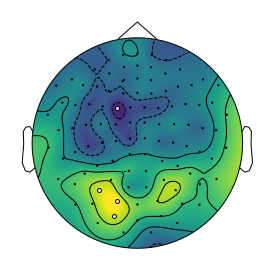

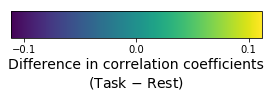

In [181]:
# take the difference of each bootstrapped iteration
bootdiff = bootrs['task']-bootrs['rest']

pvs = np.amin(
    np.stack([(bootdiff > 0).mean(axis=0), (bootdiff < 0).mean(axis=0)], axis=-1),
    axis=-1
)

# make a "mask" for all the channels that are significant
mask = pvs < 0.05

im, _ = mne.viz.plot_topomap(
    data=bootdiff.mean(axis=0), pos=pos, cmap='viridis', mask=mask,
    show=False)
plt.savefig(str(Path('.') / 'ccn-submission' / 'figures' / 'r-difference.pdf'),
            transparent=True, bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(4.5, 0.5))
ax = plt.gca()
cbar = plt.colorbar(im, cax = ax, orientation='horizontal', ticks=[-0.1, 0, 0.1])
cbar.set_label('Difference in correlation coefficients\n(Task $-$ Rest)', size=14)
plt.savefig(str(Path('.') / 'ccn-submission' / 'figures' / 'r-difference-cbar.pdf'),
            transparent=True, bbox_inches='tight')
plt.show()

### Topographic analysis: sensorimotor rt & sensorimotor 1/_f_ noise

In [37]:
rvals = []
pvals = []
recording = 'task'

megbehaviorroot = megbehaviorroot = camcanroot / 'cc700-scored' / 'MEG' / 'release001' / 'data'
megfiles = list(megbehaviorroot.glob(pattern='*/*_scored.txt'))

megdfs = []
for file in tqdm(megfiles):
    megdf = pd.read_csv(file, sep='\t')
    
    if len(megdf.index == 0):
        megdf['CCID'] = pd.Series([file.name[4:12]])
        
        megdfs.append(megdf)


megdata = pd.concat(megdfs)
megdata.set_index('CCID')
megdata.index = megdata['CCID']

megdata = megdata.drop_duplicates(subset='CCID', keep='first')

y = np.array(
    [megdata.mdnRT_inv_trim[p.pid]
     for p in summary_data[recording]
     if p.pid in megdata.index]
)

include = ~np.isnan(y)

# set things up for the cluster analysis
connectivity, ch_names = mne.channels.read_ch_connectivity('neuromag306mag')
obs = np.zeros((y.size, len(ch_names)))

for channel in tqdm(range(0, len(summary_data[recording][0].slopes), 2)):
    
    slopes = np.array(
        [np.mean([p.slopes[channel], p.slopes[channel+1]])
         if not e[channel] else np.nan
         for p, e in zip(summary_data[recording], bad_elecs[recording])
         if p.pid in megdata.index]
    )
    
    obs[:, channel//2] = slopes
    
    # exclude individuals for which this channel was bad
    include = ~np.isnan(slopes) & ~np.isnan(y)
    
    rval, pval = scipy.stats.pearsonr(slopes[include], y[include])
    rvals.append(rval)
    pvals.append(pval)

rvals = np.array(rvals)
pvals = np.array(pvals)

# corrt = corrtest(y)
# T_obs, clusters, cluster_pvs, h = mne.stats.permutation_cluster_1samp_test(
#     obs, stat_fun=corrt, connectivity=connectivity, threshold=scipy.stats.t.isf(0.05, len(y))
# )

In [40]:
corrt = corrtest(y)

T_obs, clusters, cluster_pvs, h = mne.stats.permutation_cluster_1samp_test(
    obs, stat_fun=corrt, connectivity=connectivity, threshold=scipy.stats.t.isf(0.05, len(y))
)

stat_fun(H1): min=-2.416651 max=1.620313
Running initial clustering
Found 1 clusters
Permuting ...
[........................................] 100.00000 |    Computing cluster p-values
Done.


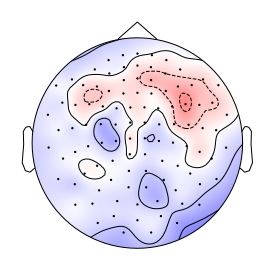

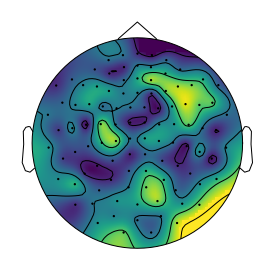

In [25]:
# mask = np.zeros_like(clusters[0], dtype=bool)
# for clust, p in zip(clusters, cluster_pvs):
#     if p < 0.05:
#         mask = mask | clust

mne.viz.plot_topomap(data=rvals, pos=pos, vmin=-0.2, vmax=0.2, cmap='bwr_r')
mne.viz.plot_topomap(data=pvals, pos=pos, vmin=0, vmax=1, cmap='viridis_r');

### Topographic analysis: VSTM & resting 1/_f_ noise

In [44]:
rvals = []
pvals = []
recording = 'rest'

y = np.array(
    [float(stm.loc[p.pid, 'Prcsn_ss2'])
     for p in summary_data[recording]
     if p.pid in stm.index]
)


# set things up for the cluster analysis
connectivity, ch_names = mne.channels.read_ch_connectivity('neuromag306mag')
obs = np.zeros((y.size, len(ch_names)))

for channel in range(0, len(summary_data[recording][0].slopes), 2):
    slopes = np.array(
        [np.mean((p.slopes[channel], p.slopes[channel+1]))
         if not e[channel] else np.nan
         for p, e in zip(summary_data[recording], bad_elecs[recording])
         if p.pid in stm.index]
    )

    include = ~np.isnan(y) & ~np.isnan(slopes)
    obs[:, channel//2] = slopes
    rval, pval = scipy.stats.pearsonr(slopes[include], y[include])
    rvals.append(rval)
    pvals.append(pval)

pvals, rvals = np.array(pvals), np.array(rvals)
# run the cluster analysis
# Do cluster analysis
corrt = corrtest(y)
T_obs, clusters, cluster_pvs, h = mne.stats.permutation_cluster_1samp_test(
    obs, stat_fun=corrt, connectivity=connectivity, threshold=scipy.stats.t.isf(0.05, len(y))
)

stat_fun(H1): min=-2.884205 max=2.811469
Running initial clustering
Found 3 clusters
Permuting ...
[........................................] 100.00000 |    Computing cluster p-values
Done.


In [46]:
pvals

array([ 0.63483688,  0.49260826,  0.5990631 ,  0.9137817 ,  0.33795147,
        0.10002403,  0.20018211,  0.42351522,  0.18479596,  0.10329765,
        0.31130264,  0.12541555,  0.30571967,  0.28459687,  0.29674481,
        0.72774158,  0.15672743,  0.43513076,  0.14048002,  0.05620856,
        0.07738012,  0.01171168,  0.11626592,  0.07529134,  0.26598141,
        0.84465004,  0.35188884,  0.37022235,  0.35712962,  0.28125733,
        0.27361949,  0.10737108,  0.29598098,  0.32720496,  0.16095462,
        0.27494932,  0.22200873,  0.02089129,  0.42433003,  0.13313962,
        0.11712669,  0.2104469 ,  0.1073702 ,  0.0425613 ,  0.07941234,
        0.13204227,  0.0297955 ,  0.23575768,  0.30216438,  0.18241094,
        0.30880397,  0.78265828,  0.99989757,  0.34380778,  0.24918103,
        0.61466412,  0.85902056,  0.57422141,  0.47092049,  0.18488471,
        0.69653859,  0.62732886,  0.66365019,  0.63591786,  0.31815449,
        0.40551369,  0.31737737,  0.3772492 ,  0.84138291,  0.88

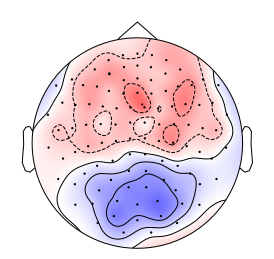

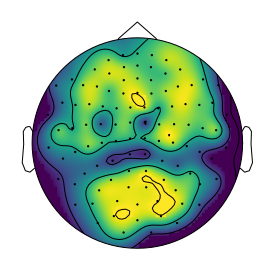

In [48]:
mask = np.zeros_like(clusters[0], dtype=bool)
for clust, p in zip(clusters, cluster_pvs):
    if p < 0.05:
        mask = mask | clust

mne.viz.plot_topomap(data=rvals, pos=pos, vmin=-0.2, vmax=0.2, cmap='bwr_r', mask=mask)
mne.viz.plot_topomap(data=pvals, pos=pos, vmin=0, vmax=1, cmap='viridis_r', mask=mask);

### Topographic analysis: motor learning

In [ ]:
motorlearning = pd.read_csv(
    camcanroot / 'cc700-scored' / 'MotorLearning' / 'release001' /
    'summary' / 'MotorLearning_summary.txt',
    sep='\t', skiprows=8, index_col=0
)

In [ ]:
recording = 'rest'
# the various behavioural metrics
preexposure = np.array([motorlearning.LatePreExposureTrajectoryErrorSD[p.pid]
                        for p in summary_data[recording] if p.pid in motorlearning.index])
exposurestart = np.array([motorlearning.EarlyExposureTrajectoryErrorMean[p.pid]
                          for p in summary_data[recording] if p.pid in motorlearning.index])
exposureend = np.array([motorlearning.LateExposureTrajectoryErrorMean[p.pid]
                        for p in summary_data[recording] if p.pid in motorlearning.index])
postexposure = np.array([motorlearning.EarlyPostExposureTrajectoryErrorSD[p.pid]
                         for p in summary_data[recording] if p.pid in motorlearning.index])

# choose which metric you want to correlate:
y = np.double(postexposure) - np.double(preexposure)

# set things up for the cluster analysis
connectivity, ch_names = mne.channels.read_ch_connectivity('neuromag306mag')
obs = np.zeros((y.size, len(ch_names)))

pvals = []
rvals = []
for channel in range(0, len(summary_data[recording][0].slopes), 2):
    slopes = np.array(
        [np.mean((p.slopes[channel], p.slopes[channel+1]))
         for p, e in zip(summary_data[recording], bad_elecs[recording])
         if p.pid in motorlearning.index]
    )
    
    obs[:, channel//2] = slopes
    rval, pval = scipy.stats.pearsonr(slopes, y)
    rvals.append(rval)
    pvals.append(pval)

pvals, rvals = np.array(pvals), np.array(rvals)
# run the cluster analysis
# Do cluster analysis
corrt = corrtest(y)
T_obs, clusters, cluster_pvs, h = mne.stats.permutation_cluster_1samp_test(
    obs, stat_fun=corrt, connectivity=connectivity, threshold=scipy.stats.t.isf(0.05, len(y))
)

In [ ]:
mask = np.zeros_like(clusters[0])
for cluster, p in zip(clusters, cluster_pvs):
    if p < 0.05:
        mask = mask | cluster

mne.viz.plot_topomap(data=rvals, pos=pos, vmin=-0.2, vmax=0.2, cmap='bwr_r', mask=mask)
mne.viz.plot_topomap(data=pvals, pos=pos, vmin=0, vmax=1, cmap='viridis_r');

### Topographic analysis: force matching

In [ ]:
forcematching = pd.read_csv(
    camcanroot / 'cc700-scored' / 'ForceMatching' / 'release001' /
    'summary' / 'ForceMatching_summary.txt',
    sep='\t', skiprows=8, index_col=0
)


In [ ]:
recording = 'rest'
# the various behavioural metrics
fingercomp = np.array([forcematching.FingerOverCompensationSD[p.pid]
                       for p in summary_data[recording] if p.pid in forcematching.index])
slidercomp = np.array([forcematching.SliderOverCompensationSD[p.pid]
                       for p in summary_data[recording] if p.pid in forcematching.index])

# choose which metric you want to correlate:
y = np.double(fingercomp) # - np.double(slidercomp)
include = ~np.isnan(y)
y = y[include]

pvals = []
rvals = []
for channel in range(0, len(summary_data[recording][0].slopes), 2):
    slopes = np.array(
        [np.mean((p.slopes[channel], p.slopes[channel+1]))
         for p in summary_data[recording]
         if p.pid in forcematching.index]
    )
    
    slopes = slopes[include]
    rval, pval = scipy.stats.pearsonr(slopes, y)
    rvals.append(rval)
    pvals.append(1-pval)

mne.viz.plot_topomap(data=rvals, pos=pos, vmin=-0.2, vmax=0.2, cmap='bwr_r')
mne.viz.plot_topomap(data=pvals, pos=pos, vmin=0.2, vmax=1, cmap='viridis');

### Topographic analysis: force matching

In [ ]:
hoteltask = pd.read_csv(
    camcanroot / 'cc700-scored' / 'Hotel' / 'release001' /
    'summary' / 'Hotel_summary.txt',
    sep='\t', skiprows=8, index_col=0
)

In [ ]:
recording = 'rest'
# the various behavioural metrics
performance = np.array([hoteltask.Time[p.pid]
                        for p in summary_data[recording] if p.pid in hoteltask.index])
qc = np.array([hoteltask.QCflag[p.pid]
               for p in summary_data[recording] if p.pid in hoteltask.index])

# choose which metric you want to correlate:
y = np.double(performance) # - np.double(slidercomp)
include = (~np.isnan(y)) & (np.double(qc) == 0)
y = y[include]

# set things up for the cluster analysis
obs = np.zeros((y.size, len(ch_names)))
connectivity, ch_names = mne.channels.read_ch_connectivity('neuromag306planar', picks=range(0, 204, 2))

pvals = []
rvals = []
for channel in range(0, len(summary_data[recording][0].slopes), 2):
    slopes = np.array(
        [np.mean((p.slopes[channel], p.slopes[channel+1]))
         for p in summary_data[recording]
         if p.pid in hoteltask.index]
    )
    # take out NaNs
    slopes = slopes[include]
    # populate data for cluster analysis
    obs[:, channel//2] = slopes
    rval, pval = scipy.stats.pearsonr(slopes, y)
    rvals.append(rval)
    pvals.append(pval)

rvals = np.array(rvals)
pvals = np.array(pvals)
# Do cluster analysis
corrt = corrtest(y)
T_obs, clusters, cluster_pvs, h = mne.stats.permutation_cluster_1samp_test(
    obs, stat_fun=corrt, connectivity=connectivity
)


In [ ]:
mask = np.zeros_like(clusters[0])
for cluster, p in zip(clusters, cluster_pvs):
    if p < 0.05:
        mask = mask | cluster

mne.viz.plot_topomap(data=rvals, pos=pos, vmin=-0.2, vmax=0.2, cmap='bwr_r', mask=mask)
mne.viz.plot_topomap(data=pvals, pos=pos, vmin=0, vmax=1, cmap='viridis_r');